# StyleGAN2 PyTorch 生成对抗网络

互联网环境里有很多公开的数据集，对于机器学习的工程和科研很有帮助，比如算法学习和效果评价。我们将使用 MNIST 这个手写字体数据集训练模型，最终生成逼真的『手写』字体效果图样。


### 数据准备

PyTorch 框架的 torchvision.datasets 包提供了 MNIST 数据集，您可以通过如下指令下载 MNIST 数据集到本地备用。
(为方便国内读者使用，将 QMNIST 数据集替换为 MNIST 数据集，经测试训练数据的下载速度提高了很多)

In [1]:
from torchvision import datasets

dataroot = './data'

trainset = datasets.MNIST(root=dataroot, train=True, download=True)
testset = datasets.MNIST(root=dataroot, train=False, download=True)

Amazon SageMaker 为您创建了一个默认的 Amazon S3 桶，用来存取机器学习工作流程中可能需要的各种文件和数据。 我们可以通过 SageMaker SDK 中 sagemaker.session.Session 类的 default_bucket 方法获得这个桶的名字。

In [2]:
from sagemaker.session import Session

sess = Session()

# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket here if you wish.
bucket = sess.default_bucket()

# Location to save your custom code in tar.gz format.
s3_custom_code_upload_location = f's3://{bucket}/customcode/byos-pytorch-gan'

# Location where results of model training are saved.
s3_model_artifacts_location = f's3://{bucket}/artifacts/'

SageMaker SDK 提供了操作 Amazon S3 服务的包和类，其中 S3Downloader 类用于访问或下载 S3 里的对象，而 S3Uploader 则用于将本地文件上传至 S3。您将已经下载的数据上传至 Amazon S3，供模型训练使用。模型训练过程不要从互联网下载数据，避免通过互联网获取训练数据的产生的网络延迟，同时也规避了因直接访问互联网对模型训练可能产生的安全风险。


In [3]:
import os
from sagemaker.s3 import S3Uploader as s3up

s3_data_location = s3up.upload(os.path.join(dataroot, "MNIST"), f"s3://{bucket}/data/mnist")

### 训练执行




通过 sagemaker.get_execution_role() 方法，当前笔记本可以得到预先分配给笔记本实例的角色，这个角色将被用来获取训练用的资源，比如下载训练用框架镜像、分配 Amazon EC2 计算资源等等。

In [4]:
from sagemaker import get_execution_role

# IAM execution role that gives SageMaker access to resources in your AWS account.
# We can use the SageMaker Python SDK to get the role from our notebook environment. 
role = get_execution_role()

训练模型用的超参数可以在笔记本里定义，实现与算法代码的分离，在创建训练任务时传入超参数，与训练任务动态结合。

In [5]:
import json

hps = {
         'seed': 0,
         'learning-rate': 0.0002,
         'epochs': 15,
         'dataset': 'mnist',
         'pin-memory': 1,
         'beta1': 0.5,
         'nc': 1,
         'nz': 100,
         'ngf': 64,
         'ndf': 64,
         'batch-size': 64,
         'sample-interval': 100,
         'log-interval': 20,
     }


print(json.dumps(hps, indent = 4))

{
    "seed": 0,
    "learning-rate": 0.0002,
    "epochs": 15,
    "dataset": "mnist",
    "pin-memory": 1,
    "beta1": 0.5,
    "nc": 1,
    "nz": 100,
    "ngf": 64,
    "ndf": 64,
    "batch-size": 64,
    "sample-interval": 100,
    "log-interval": 20
}


sagemaker.pytorch 包里的 ```PyTorch``` 类是基于 PyTorch 框架的模型拟合器，可以用来创建、执行训练任务，还可以对训练完的模型进行部署。参数列表中， ``train_instance_type`` 用来指定CPU或者GPU实例类型，训练脚本和包括模型代码所在的目录通过 ``source_dir`` 指定，训练脚本文件名必须通过 ``entry_point`` 明确定义。这些参数将和其余参数一起被传递给训练任务，他们决定了训练任务的运行环境和模型训练时参数。

In [7]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(role=role,
                        entry_point='train.py',
                        source_dir='stylegan2',
                        output_path=s3_model_artifacts_location,
                        code_location=s3_custom_code_upload_location,
                        train_instance_count=1,
                        train_instance_type='ml.p3.2xlarge',
                        train_use_spot_instances=True,
                        train_max_wait=86400,
                        framework_version='1.4.0',
                        py_version='py3',
                        hyperparameters=hps)

请特别注意 ``train_use_spot_instances`` 参数，``True`` 值代表您希望优先使用 SPOT 实例。由于机器学习训练工作通常需要大量计算资源长时间运行，善用 SPOT 可以帮助您实现有效的成本控制，SPOT 实例价格可能是按需实例价格的 20% 到 60%，依据选择实例类型、区域、时间不同实际价格有所不同。 

您已经创建了 PyTorch 对象，下面可以用它来拟合预先存在 Amazon S3 上的数据了。下面的指令将执行训练任务，训练数据将以名为 **MNIST** 的输入通道的方式导入训练环境。训练开始执行过程中，Amazon S3 上的训练数据将被下载到模型训练环境的本地文件系统，训练脚本 ```train.py``` 将从本地磁盘加载数据进行训练。

In [8]:
# Start training
estimator.fit({"MNIST": s3_data_location}, wait=False)

根据您选择的训练实例不同，训练过程中可能持续几十分钟到几个小时不等。建议设置 ``wait`` 参数为 ``False`` ，这个选项将使笔记本与训练任务分离，在训练时间长、训练日志多的场景下，可以避免笔记本上下文因为网络中断或者会话超时而丢失。训练任务脱离笔记本后，输出将暂时不可见，可以执行如下代码，笔记本将获取并载入此前的训练回话，

In [9]:
%%time
from sagemaker.estimator import Estimator

# Attaching previous training session
training_job_name = estimator.latest_training_job.name
attached_estimator = Estimator.attach(training_job_name)

2020-05-18 13:06:16 Starting - Starting the training job...
2020-05-18 13:06:22 Starting - Launching requested ML instances......
2020-05-18 13:07:23 Starting - Preparing the instances for training............
2020-05-18 13:09:47 Downloading - Downloading input data
2020-05-18 13:09:47 Training - Downloading the training image.........
2020-05-18 13:11:03 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-05-18 13:11:04,056 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-05-18 13:11:04,080 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-05-18 13:11:10,296 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-05-18 13:11:12,260 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2020

UnexpectedStatusException: Error for Training job pytorch-training-2020-05-18-13-06-10-061: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
Command "/opt/conda/bin/python train.py --batch-size 64 --beta1 0.5 --dataset mnist --epochs 15 --learning-rate 0.0002 --log-interval 20 --nc 1 --ndf 64 --ngf 64 --nz 100 --pin-memory 1 --sample-interval 100 --seed 0"
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/cpp_extension.py", line 929, in verify_ninja_availability
    subprocess.check_call('ninja --version'.split(), stdout=devnull)
  File "/opt/conda/lib/python3.6/subprocess.py", line 286, in check_call
    retcode = call(*popenargs, **kwargs)
  File "/opt/conda/lib/python3.6/subprocess.py", line 267, in call
    with Popen(*popenargs, **kwargs) as p:
  File "/opt/conda/lib/python3.6/subprocess.py", line 709, in __init__
    restore_signals, start_new_session)
  File "/opt/conda/lib/python3.6/subprocess.py", line 1344, in _execute_child
    raise child_exception_type(errno_num, err_msg, err_filename)
FileNotFoundError: [Errno 2] No such file or directory: 'ninja': 'n

In [ ]:
from sagemaker.predictor import RealTimePredictor

class PganPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super().__init__(endpoint_name, sagemaker_session=sagemaker_session, serializer=serialize, 
                         deserializer=deserialize, content_type='application/x-npy',
                         accept='application/x-npy')

In [ ]:
from sagemaker.model import Model
from sagemaker.pytorch.model import PyTorchModel

model = attached_estimator.create_model(role=role,
                                     predictor_cls=PganPredictor,
                                     name=model_name,
                                     entry_point='inference.py',
                                     py_version="py3",
                                     framework_version="1.5",
                                     sagemaker_session=sess)

In [ ]:
%%time
import time

endpoint_name = f'endpoint-{model_algorithm}-{model_pretrained_name}-' \
                    + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

predictor = model.deploy(endpoint_name=endpoint_name,
#                          instance_type='local',
                         instance_type='ml.c5.xlarge',
                         initial_instance_count=1)
                            

### Invoke the endpoint

Let's test with a cat image.

In [ ]:
noises = generate_noises(1)
output = predictor.predict(noises)

show_multiple_pictures(output)

In [ ]:
model.delete_model()

In [ ]:
predictor.delete_endpoint(delete_endpoint_config=True)

### Create a boto3 session and get specify a role with SageMaker access
https://github.com/rosinality/stylegan2-pytorch.git

In [ ]:
import boto3
import sagemaker
from sagemaker.utils import name_from_base

role = sagemaker.get_execution_role()
account_id = role.split(':')[4]

sess = sagemaker.Session()
region = sess.boto_region_name
bucket = sess.default_bucket()

print(account_id)
print(region)
print(role)
print(bucket)

### Download PGAN-CelebAHQ-512 model

We'll download [Progressive GAN](https://arxiv.org/abs/1710.10196) pre-trained model [PGAN-CelebAHQ-512](https://pytorch.org/hub/facebookresearch_pytorch-gan-zoo_pgan/) from Torch Hub, which is trained on high-quality celebrity faces "celebA" dataset, then create a model artifact `model.tar.gz` and upload it to S3:

In [5]:
from sagemaker.s3 import S3Downloader as s3down
import os

use_gpu = False
model_algorithm = 'StyleGAN'

# this model outputs 512 x 512 pixel images
model_pretrained_name = '512px-new'

s3_model_location = 's3://sagemaker-cn-northwest-1-940330773118/data-do-not-delete/pre-trained-model/stylegan-512px-new.model.pth'
model_file_name = os.path.basename(s3_model_location)

s3down.download(s3_model_location, f'./tmp')

In [7]:
print(model_file_name)

stylegan-512px-new.model.pth


In [6]:
import helper
import importlib

importlib.reload(helper)

model = helper.load_model(f'./tmp/{model_file_name}') #f'./tmp/{model_algorithm}-{model_pretrained_name}.pth')

RuntimeError: [enforce fail at inline_container.cc:143] . PytorchStreamReader failed reading zip archive: failed finding central directory


In [2]:
def generate_noises(num_images=1):
    import torch
    
    noises = torch.randn(num_images, 512)
    
    return noises


def show_multiple_pictures(pics):
    # let's plot these images using torchvision and matplotlib
    import matplotlib.pyplot as plt
    import torchvision
    import torch

    generated_images = torch.Tensor(pics)
    grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1),
                                       scale_each=True, normalize=True)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.show()

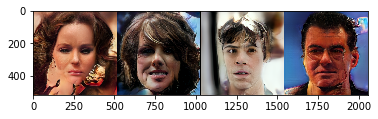

In [5]:
netG = pgan.netG

noises = generate_noises(4)

with torch.no_grad():
    generated_images = netG(noises)

show_multiple_pictures(generated_images)
# print(netG)

In [6]:
import time

model_name = f'model-{model_algorithm}-{model_pretrained_name}-' \
                    + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

model_folder = f'./tmp/{model_algorithm}'
!mkdir -p {model_folder}

input_shape = [1, 512]
# data_shape = '{"input0":[1, 512]}'

traced_model = torch.jit.trace(netG.float().eval(), torch.zeros(input_shape).float())
# scripted_model = torch.jit.script(model)
traced_model.save(f"{model_folder}/{model_name}.pth")

### Download a PyTorch model and create a TorchServe archive



In [7]:
!rm -rf ./model/*

!cp -af {model_folder}/{model_name}.pth ./model/model.pth
!cp -af pgan ./model/code

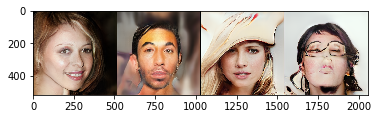

In [8]:
from pgan import model_tools
import torch

netG = model_tools.load_pgan_netG("./model/model.pth", device="cpu")
# print(gnet)

noises = generate_noises(4)
with torch.no_grad():
    generated_images = netG(noises)

show_multiple_pictures(generated_images)

In [9]:
def serialize(nparray, content_type='application/x-npy'):
    from io import BytesIO
    import numpy as np

    if content_type == 'application/json':
        deserialized = json.dumps(nparray.tolist())
    else:
        array_like = nparray.tolist()
        buffer = BytesIO()
        np.save(buffer, array_like)
        deserialized = buffer.getvalue()

    return deserialized


def deserialize(serialized, content_type='application/x-npy'):
    from io import BytesIO
    import numpy as np
    from botocore.response import StreamingBody

    if isinstance(serialized, StreamingBody):
        stream = BytesIO(serialized.read())
    else:
        stream = BytesIO(serialized)

    np_output = np.load(stream, allow_pickle=True)
    
    return np_output

/home/ec2-user/SageMaker/ml-on-aws.git/byos-pytorch-gan/model/code


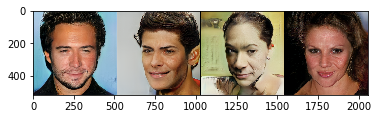

/home/ec2-user/SageMaker/ml-on-aws.git/byos-pytorch-gan


In [10]:
%cd ./model/code
import json
from inference import context
import handler

import importlib
importlib.reload(handler)

ctxt = context("..")

noises = generate_noises(4)
x = serialize(noises.numpy())

output = handler.handle([{'data':x}], ctxt)

show_multiple_pictures(output[0])

%cd ../..

/home/ec2-user/SageMaker/ml-on-aws.git/byos-pytorch-gan/model/code


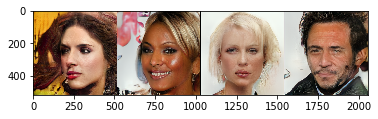

/home/ec2-user/SageMaker/ml-on-aws.git/byos-pytorch-gan


In [11]:
%cd ./model/code
import json
import inference

import importlib

importlib.reload(inference)

noises = generate_noises(4)
noises_serialized = serialize(noises.numpy())

model = inference.model_fn("..")

input_data = inference.input_fn(noises_serialized, 'application/x-npy')

prediction = inference.predict_fn(input_data, model)
images_serialized = inference.output_fn(prediction, 'application/x-npy')

show_multiple_pictures(deserialize(images_serialized))

%cd ../..

### Set up the environment

In [13]:
import tarfile
import time

with tarfile.open(f"{model_folder}/{model_name}.tar.gz", 'w:gz') as f:
    f.add(f"./model/model.pth", arcname="model.pth")
    f.add(f"./model/code", arcname="code")

<code>
model.tar.gz/
|- model.pth
|- code/
  |- inference.py
  |- requirements.txt  # only for versions 1.3.1 and higher
</code>

### Upload the generated model archive file to Amazon S3
Create a compressed tar.gz file from the densenet161.mar file since Amazon SageMaker expects that models are in a tar.gz file. 
Uploads the model to your default Amazon SageMaker S3 bucket under the models directory

In [14]:
s3_model_location = sess.upload_data(path=f"{model_folder}/{model_name}.tar.gz",
                              key_prefix=f"artifacts/models")

In [16]:
from sagemaker.predictor import RealTimePredictor

class PganPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super().__init__(endpoint_name, sagemaker_session=sagemaker_session, serializer=serialize, 
                         deserializer=deserialize, content_type='application/x-npy',
                         accept='application/x-npy')

In [17]:
from sagemaker.model import Model
from sagemaker.pytorch.model import PyTorchModel

model = PyTorchModel(model_data=s3_model_location,
                     role=role,
                     predictor_cls=PganPredictor,
                     name=model_name,
                     entry_point='inference.py',
                     py_version="py3",
                     framework_version="1.5",
                     sagemaker_session=sess)

In [18]:
%%time
import time

endpoint_name = f'endpoint-{model_algorithm}-{model_pretrained_name}-' \
                    + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

predictor = model.deploy(endpoint_name=endpoint_name,
#                          instance_type='local',
                         instance_type='ml.c5.xlarge',
                         initial_instance_count=1)
                            

-----------!CPU times: user 6.28 s, sys: 854 ms, total: 7.14 s
Wall time: 5min 37s


### Invoke the endpoint

Let's test with a cat image.

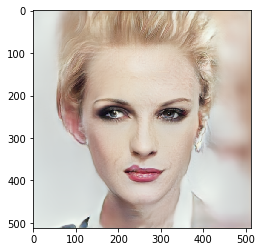

In [19]:
noises = generate_noises(1)
output = predictor.predict(noises)

show_multiple_pictures(output)

In [ ]:
model.delete_model()

In [ ]:
predictor.delete_endpoint(delete_endpoint_config=True)

SageMaker SDK 提供了操作 Amazon S3 服务的包和类，其中 S3Downloader 类用于访问或下载 S3 里的对象，而 S3Uploader 则用于将本地文件上传至 S3。您将已经下载的数据上传至 Amazon S3，供模型训练使用。模型训练过程不要从互联网下载数据，避免通过互联网获取训练数据的产生的网络延迟，同时也规避了因直接访问互联网对模型训练可能产生的安全风险。


### 训练执行




通过 sagemaker.get_execution_role() 方法，当前笔记本可以得到预先分配给笔记本实例的角色，这个角色将被用来获取训练用的资源，比如下载训练用框架镜像、分配 Amazon EC2 计算资源等等。

训练模型用的超参数可以在笔记本里定义，实现与算法代码的分离，在创建训练任务时传入超参数，与训练任务动态结合。

sagemaker.pytorch 包里的 ```PyTorch``` 类是基于 PyTorch 框架的模型拟合器，可以用来创建、执行训练任务，还可以对训练完的模型进行部署。参数列表中， ``train_instance_type`` 用来指定CPU或者GPU实例类型，训练脚本和包括模型代码所在的目录通过 ``source_dir`` 指定，训练脚本文件名必须通过 ``entry_point`` 明确定义。这些参数将和其余参数一起被传递给训练任务，他们决定了训练任务的运行环境和模型训练时参数。

请特别注意 ``train_use_spot_instances`` 参数，``True`` 值代表您希望优先使用 SPOT 实例。由于机器学习训练工作通常需要大量计算资源长时间运行，善用 SPOT 可以帮助您实现有效的成本控制，SPOT 实例价格可能是按需实例价格的 20% 到 60%，依据选择实例类型、区域、时间不同实际价格有所不同。 

您已经创建了 PyTorch 对象，下面可以用它来拟合预先存在 Amazon S3 上的数据了。下面的指令将执行训练任务，训练数据将以名为 **QMNIST** 的输入通道的方式导入训练环境。训练开始执行过程中，Amazon S3 上的训练数据将被下载到模型训练环境的本地文件系统，训练脚本 ```train.py``` 将从本地磁盘加载数据进行训练。

In [ ]:
!conda install -c conda-forge ipywidgets nodejs
!conda update -y tqdm

In [ ]:
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

## Example: PyTorch deployments using TorchServe and Amazon SageMaker

In this example, we’ll show you how you can build a TorchServe container and host it using Amazon SageMaker. With Amazon SageMaker hosting you get a fully-managed hosting experience. Just specify the type of instance, and the maximum and minimum number desired, and SageMaker takes care of the rest.

With a few lines of code, you can ask Amazon SageMaker to launch the instances, download your model from Amazon S3 to your TorchServe container, and set up the secure HTTPS endpoint for your application. On the client side, get prediction with a simple API call to this secure endpoint backed by TorchServe.

Code, configuration files, Jupyter notebooks and Dockerfiles used in this example are available here:
https://github.com/shashankprasanna/torchserve-examples.git


In [ ]:
#For CPU
!conda install -y -c pytorch -c powerai pytorch=1.5 torchtext torchvision

In [ ]:
#For GPU
!conda install -y -c pytorch -c powerai pytorch=1.5 torchtext torchvision cudatoolkit=10.1

In [ ]:
!git clone https://github.com/facebookresearch/pytorch_GAN_zoo.git pytorch_GAN_zoo.git

In [ ]:
!python3 pytorch_GAN_zoo/train.py StyleGAN -c pytorch_GAN_zoo/config_celebaHQ.json --restart -n style_gan_celeba